In [2]:
# importing packages 
import numpy as np
import emcee
import corner
import rebound

from scipy.optimize import least_squares
from scipy.optimize import leastsq

from matplotlib import pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = "retina"

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"]  = 100

# importing functions
from functions_new_parameters import E_from_M
from functions_new_parameters import generate_pm_signal
from functions_new_parameters import generate_parallax_signal
from functions_new_parameters import thiele_innes
from functions_new_parameters import generate_planet_signal
from functions_new_parameters import find_param_from_var
from functions_new_parameters import func
from functions_new_parameters import normalized_residuals
from functions_new_parameters import log_likelihood
from functions_new_parameters import log_prior
from functions_new_parameters import log_probability

# unit conversion 
rad_mas = 206264806

# times 
times = np.linspace(0, 4.2, 60)

### Least squares fit 

var1 = $\sqrt{\cos i}\cos\Omega$ \
var2 = $\sqrt{\cos i} \sin{\Omega}$ \
var3 = $\sqrt{e}\cos{\omega}$ \
var4 = $\sqrt{e}\sin\omega$ 

#### Functions

#### Setting the true parameters and using them  to create true data and adding some noise/error to that data to make the observed data 

In [3]:
parameters = ['alpha', 'delta', 'mu_alpha', 'mu_delta', 'parallax', 'sqrt(cos(i)cos(Omega)', 'sqrt(cosi)sin(Omega)', 'sqrt(e)cos(omega)', 'sqrt(e)sin(omega)' ,'a_AU', 'P_orb', 't_peri']
planet_parameters = ['e', 'omega', 'Omega', 'i']

alpha_true    = 0.7853981641246757
delta_true    = 0.7853981637587035
mu_alpha_true = 2.3084641853871365e-07
mu_delta_true = 1.770935480191023e-07
parallax_true = 9.699321049402031e-08
omega_true    = 2
Omega_true    = 1
inc_true      = 0.2
e_true        = 0.2
a_AU_true     = 0.6 
P_orb_true    = 0.46146592515998475
t_peri_true   = 0.0

var1_true = np.sqrt(np.cos(inc_true)) * np.cos(Omega_true) 
var2_true = np.sqrt(np.cos(inc_true)) * np.sin(Omega_true)
var3_true = np.sqrt(e_true)           * np.cos(omega_true)
var4_true = np.sqrt(e_true)           * np.sin(omega_true)

truepars = np.array((alpha_true, delta_true, mu_alpha_true, mu_delta_true, parallax_true, var1_true, var2_true, var3_true, var4_true, a_AU_true, P_orb_true, t_peri_true))

In [4]:
pm_ra_true, prlx_ra_true, true_plnt_ra, true_ra, pm_dec_true, prlx_dec_true, true_plnt_dec, true_dec = func(truepars, times)

sigma_err = (1e-5*np.pi/180/60/60)*5

ra_obs  = true_ra   +  np.random.normal(0, sigma_err, len(true_ra)) 
dec_obs = true_dec  +  np.random.normal(0, sigma_err, len(true_dec)) 

#### Make a guess, use it to do a least squares fit and plot the data 

In [5]:
np.random.seed(36)
constant = np.random.uniform(0,0.01)
guess = truepars * (1 + constant)

In [6]:
best, cov, _ , _ , _ = leastsq(normalized_residuals, guess, args=(sigma_err, ra_obs, dec_obs), full_output=1)

best

array([ 7.85398164e-01,  7.85398164e-01,  2.30826161e-07,  1.77124505e-07,
        9.70006473e-08,  5.25843951e-01,  8.34460278e-01, -1.88292223e-01,
        4.31006713e-01,  6.07243451e-01,  4.60171656e-01,  8.06572001e-03])

In [7]:
# LS fit
result_LS = least_squares(normalized_residuals, guess, args=(sigma_err, ra_obs, dec_obs)) 

planet_param_LS = find_param_from_var(result_LS.x[5], result_LS.x[6], result_LS.x[7], result_LS.x[8])

# data from best fit 
_, _, best_plnt_ra, best_ra, _, _, best_plnt_dec, best_dec = func(best, times) # func(result_LS.x, times)

planet_param_best = find_param_from_var(best[5], best[6], best[7], best[8])

Lest-squares estimates:
alpha                  = 0.7853981641708375
delta                  = 0.7853981636393905
mu_alpha               = 2.308283376548296e-07
mu_delta               = 1.7713426926021585e-07
parallax               = 9.699226129502208e-08
sqrt(cos(i)cos(Omega)  = 0.5357686266201293
sqrt(cosi)sin(Omega)   = 0.8211026845183987
sqrt(e)cos(omega)      = -0.20535818023817978
sqrt(e)sin(omega)      = 0.41363068766314237
a_AU                   = 0.5815704096544663
P_orb                  = 0.4603146289628236
t_peri                 = 0.008773392563328404
e                      = 0.22122074825050153
omega                  = 1.9826745867207303
Omega                  = 1.0084946552577514
i                      = 0.9728358156194785


Text(0.5, 1.0, 'Signal')

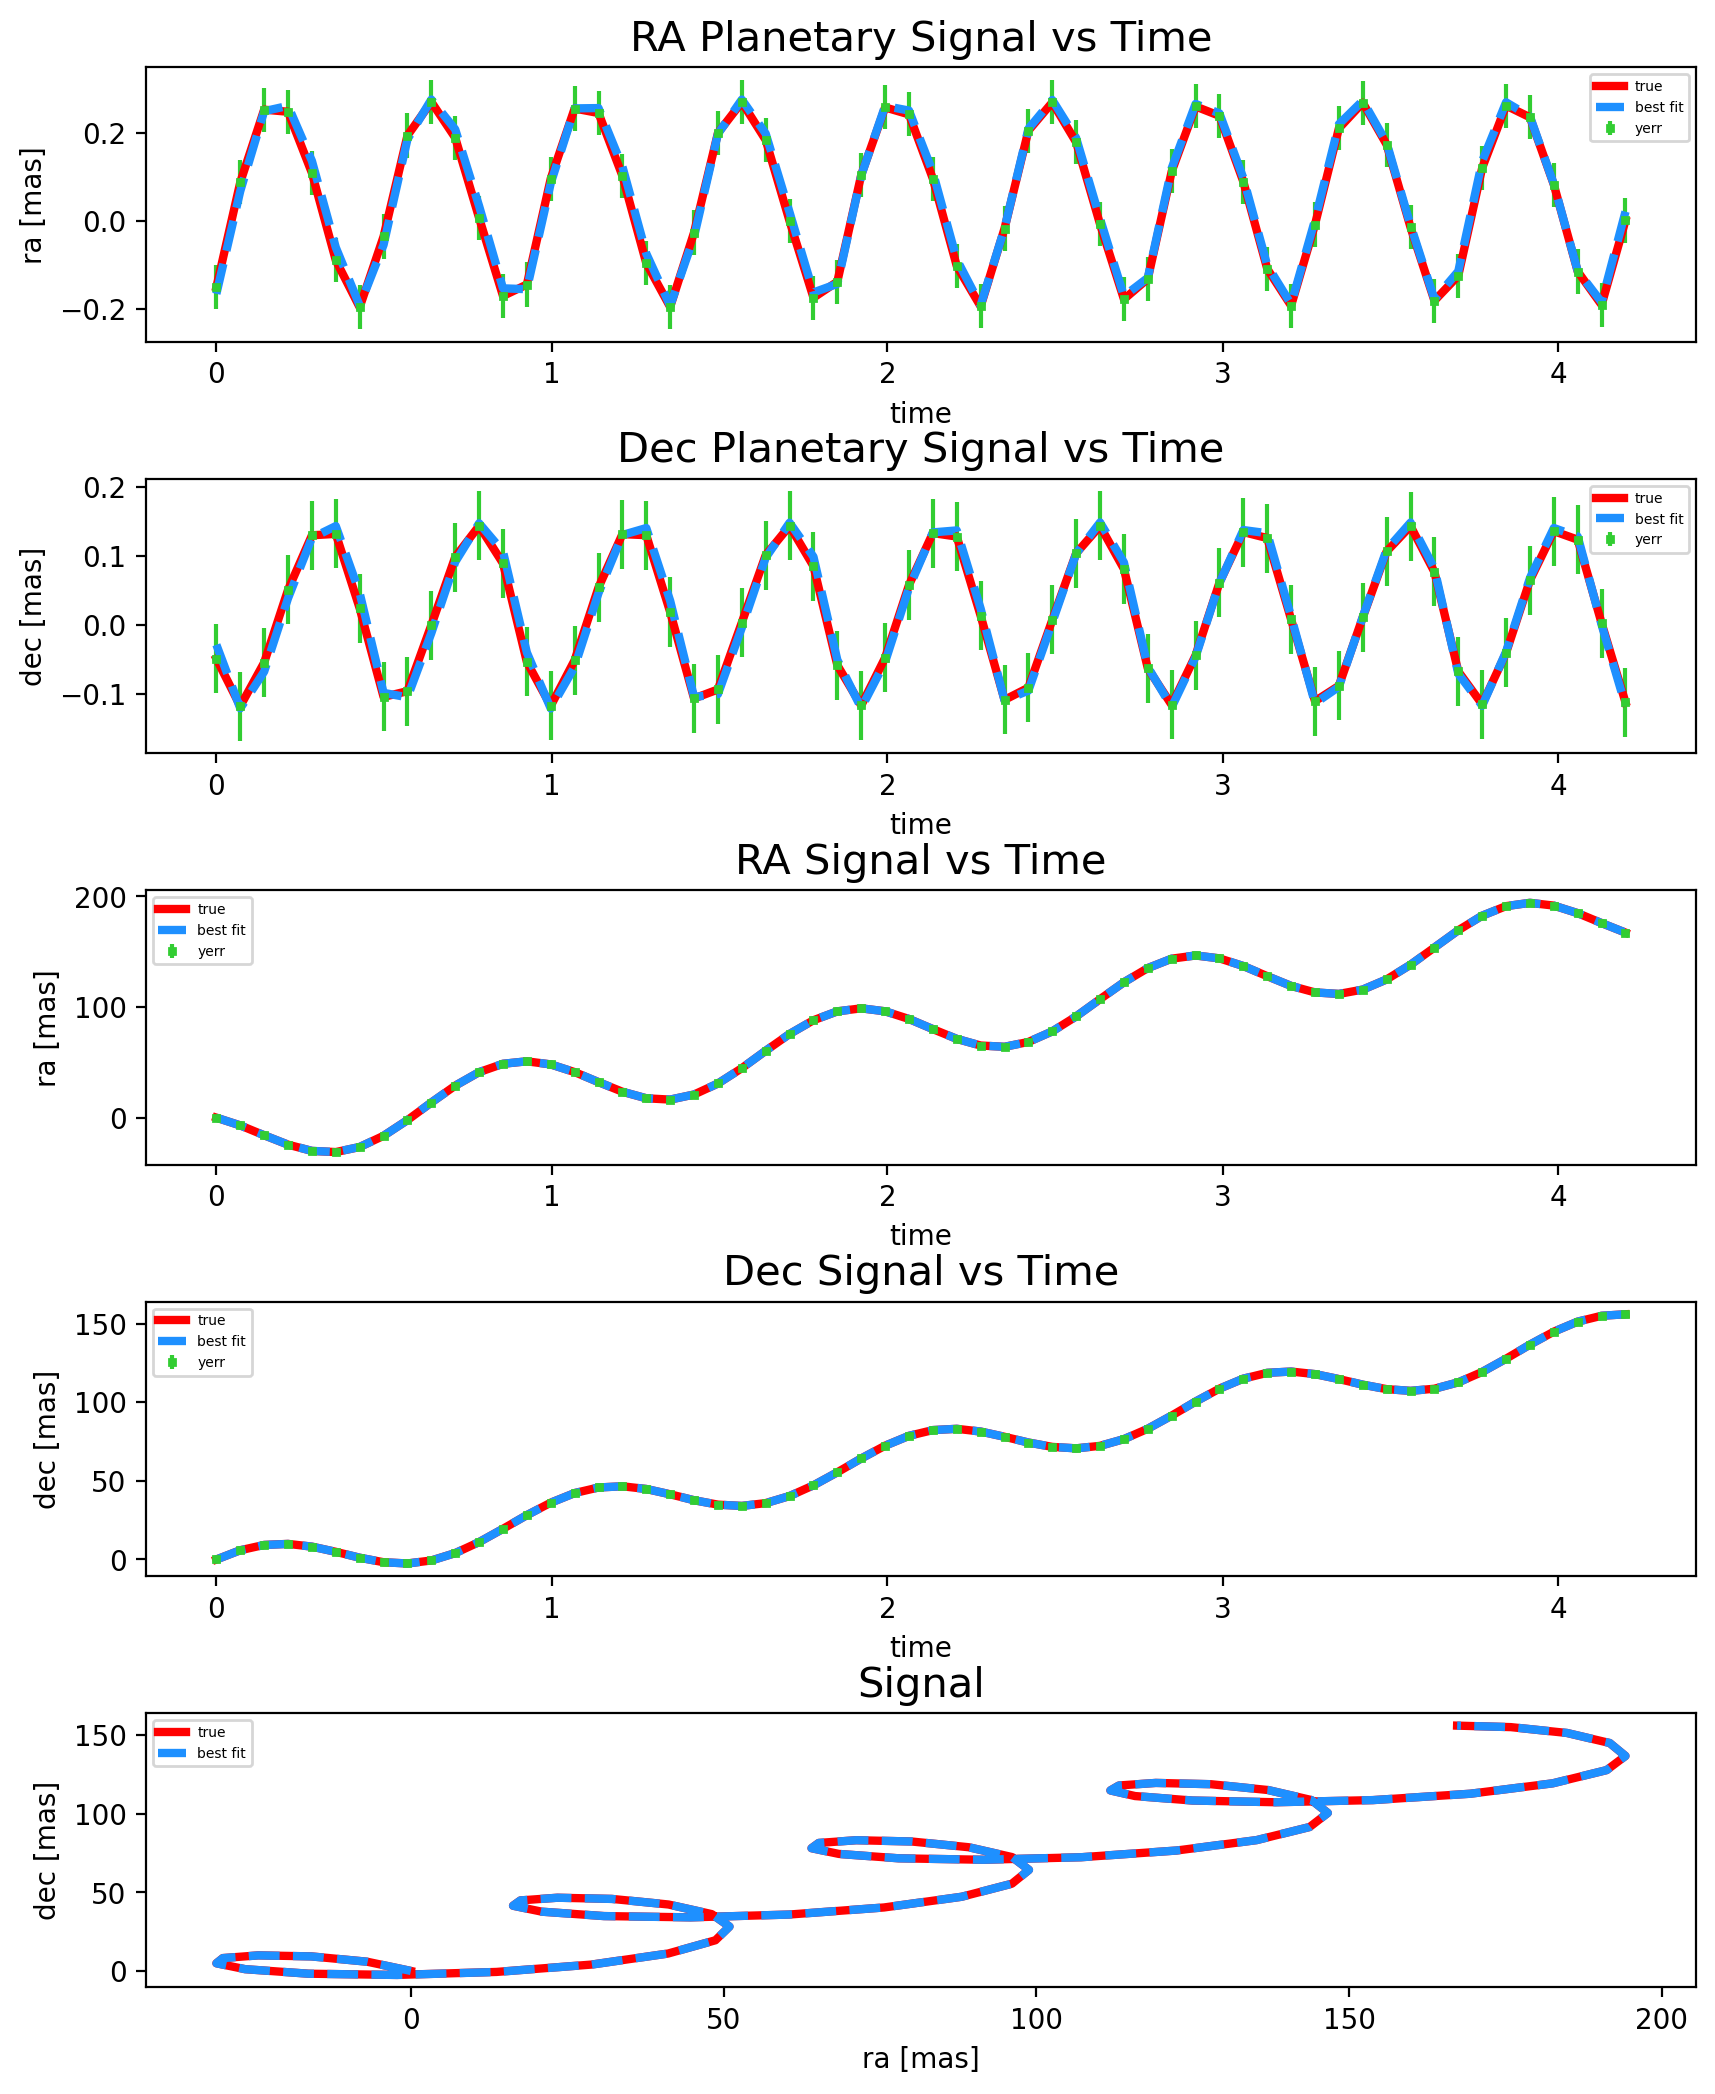

In [8]:
# printing the parameters that the LS fit calculated 
print("Lest-squares estimates:")
for i in range(0, len(parameters)):
    print(parameters[i],(21-len(parameters[i]))*' ','=', result_LS.x[i])
    
for j in range(0, len(planet_parameters)):
    print(planet_parameters[j],(21-len(planet_parameters[j]))*' ','=', planet_param_best[j])
    
# plotting data 
fig, ax = plt.subplots(5, 1, figsize=(10, 12), sharex=False)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

ax[0].errorbar(times, (true_plnt_ra)*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[0].plot(times, (true_plnt_ra)*rad_mas, lw=3, color='red'       , label='true')
ax[0].plot(times, (best_plnt_ra)*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--')
ax[0].legend(fontsize=5)
ax[0].set_xlabel("time", fontsize = 10)
ax[0].set_ylabel("ra [mas]", fontsize = 10)
ax[0].set_title("RA Planetary Signal vs Time", fontsize = 15)

ax[1].errorbar(times, (true_plnt_dec)*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[1].plot(times, (true_plnt_dec)*rad_mas, lw=3, color='red'       , label='true')
ax[1].plot(times, (best_plnt_dec)*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--', )
ax[1].legend(fontsize=5)
ax[1].set_xlabel("time", fontsize = 10)
ax[1].set_ylabel("dec [mas]", fontsize = 10)
ax[1].set_title("Dec Planetary Signal vs Time", fontsize = 15)

ax[2].errorbar(times, (true_ra-true_ra[0])*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[2].plot(times, (true_ra-true_ra[0])*rad_mas, lw=3, color='red'       , label='true')
ax[2].plot(times, (best_ra-best_ra[0])*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--')
ax[2].legend(fontsize=5)
ax[2].set_xlabel("time", fontsize = 10)
ax[2].set_ylabel("ra [mas]", fontsize = 10)
ax[2].set_title("RA Signal vs Time", fontsize = 15)

ax[3].errorbar(times, (true_dec-true_dec[0])*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[3].plot(times, (true_dec-true_dec[0])*rad_mas, lw=3, color='red'       , label='true')
ax[3].plot(times, (best_dec-best_dec[0])*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--', )
ax[3].legend(fontsize=5)
ax[3].set_xlabel("time", fontsize = 10)
ax[3].set_ylabel("dec [mas]", fontsize = 10)
ax[3].set_title("Dec Signal vs Time", fontsize = 15)

ax[4].plot((true_ra-true_ra[0])*rad_mas, (true_dec-true_dec[0])*rad_mas, lw=3, color='red'       , label='true')
ax[4].plot((true_ra-best_ra[0])*rad_mas, (best_dec-best_dec[0])*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--', )
ax[4].legend(fontsize=5)
ax[4].set_xlabel("ra [mas]", fontsize = 10)
ax[4].set_ylabel("dec [mas]", fontsize = 10)
ax[4].set_title("Signal", fontsize = 15)

### MCMC

#### log functions 

#### create pos and check if log_probability is finite 

In [9]:
np.random.seed(23)
pos = result_LS.x*(1+1e-4 * np.random.randn(32, 12)) 
nwalkers, ndim = pos.shape

check = np.isfinite([log_probability(z, true_ra, true_dec, sigma_err) for z in pos])
check 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [10]:
initials_good = np.alltrue(np.isfinite([log_probability(z, true_ra, true_dec, sigma_err) for z in pos]))

assert initials_good

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (true_ra, true_dec, sigma_err))

sampler.run_mcmc(pos, 1000, progress = True);

100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 33.46it/s]


#### Plot value calculated vs step number for each of the parametes

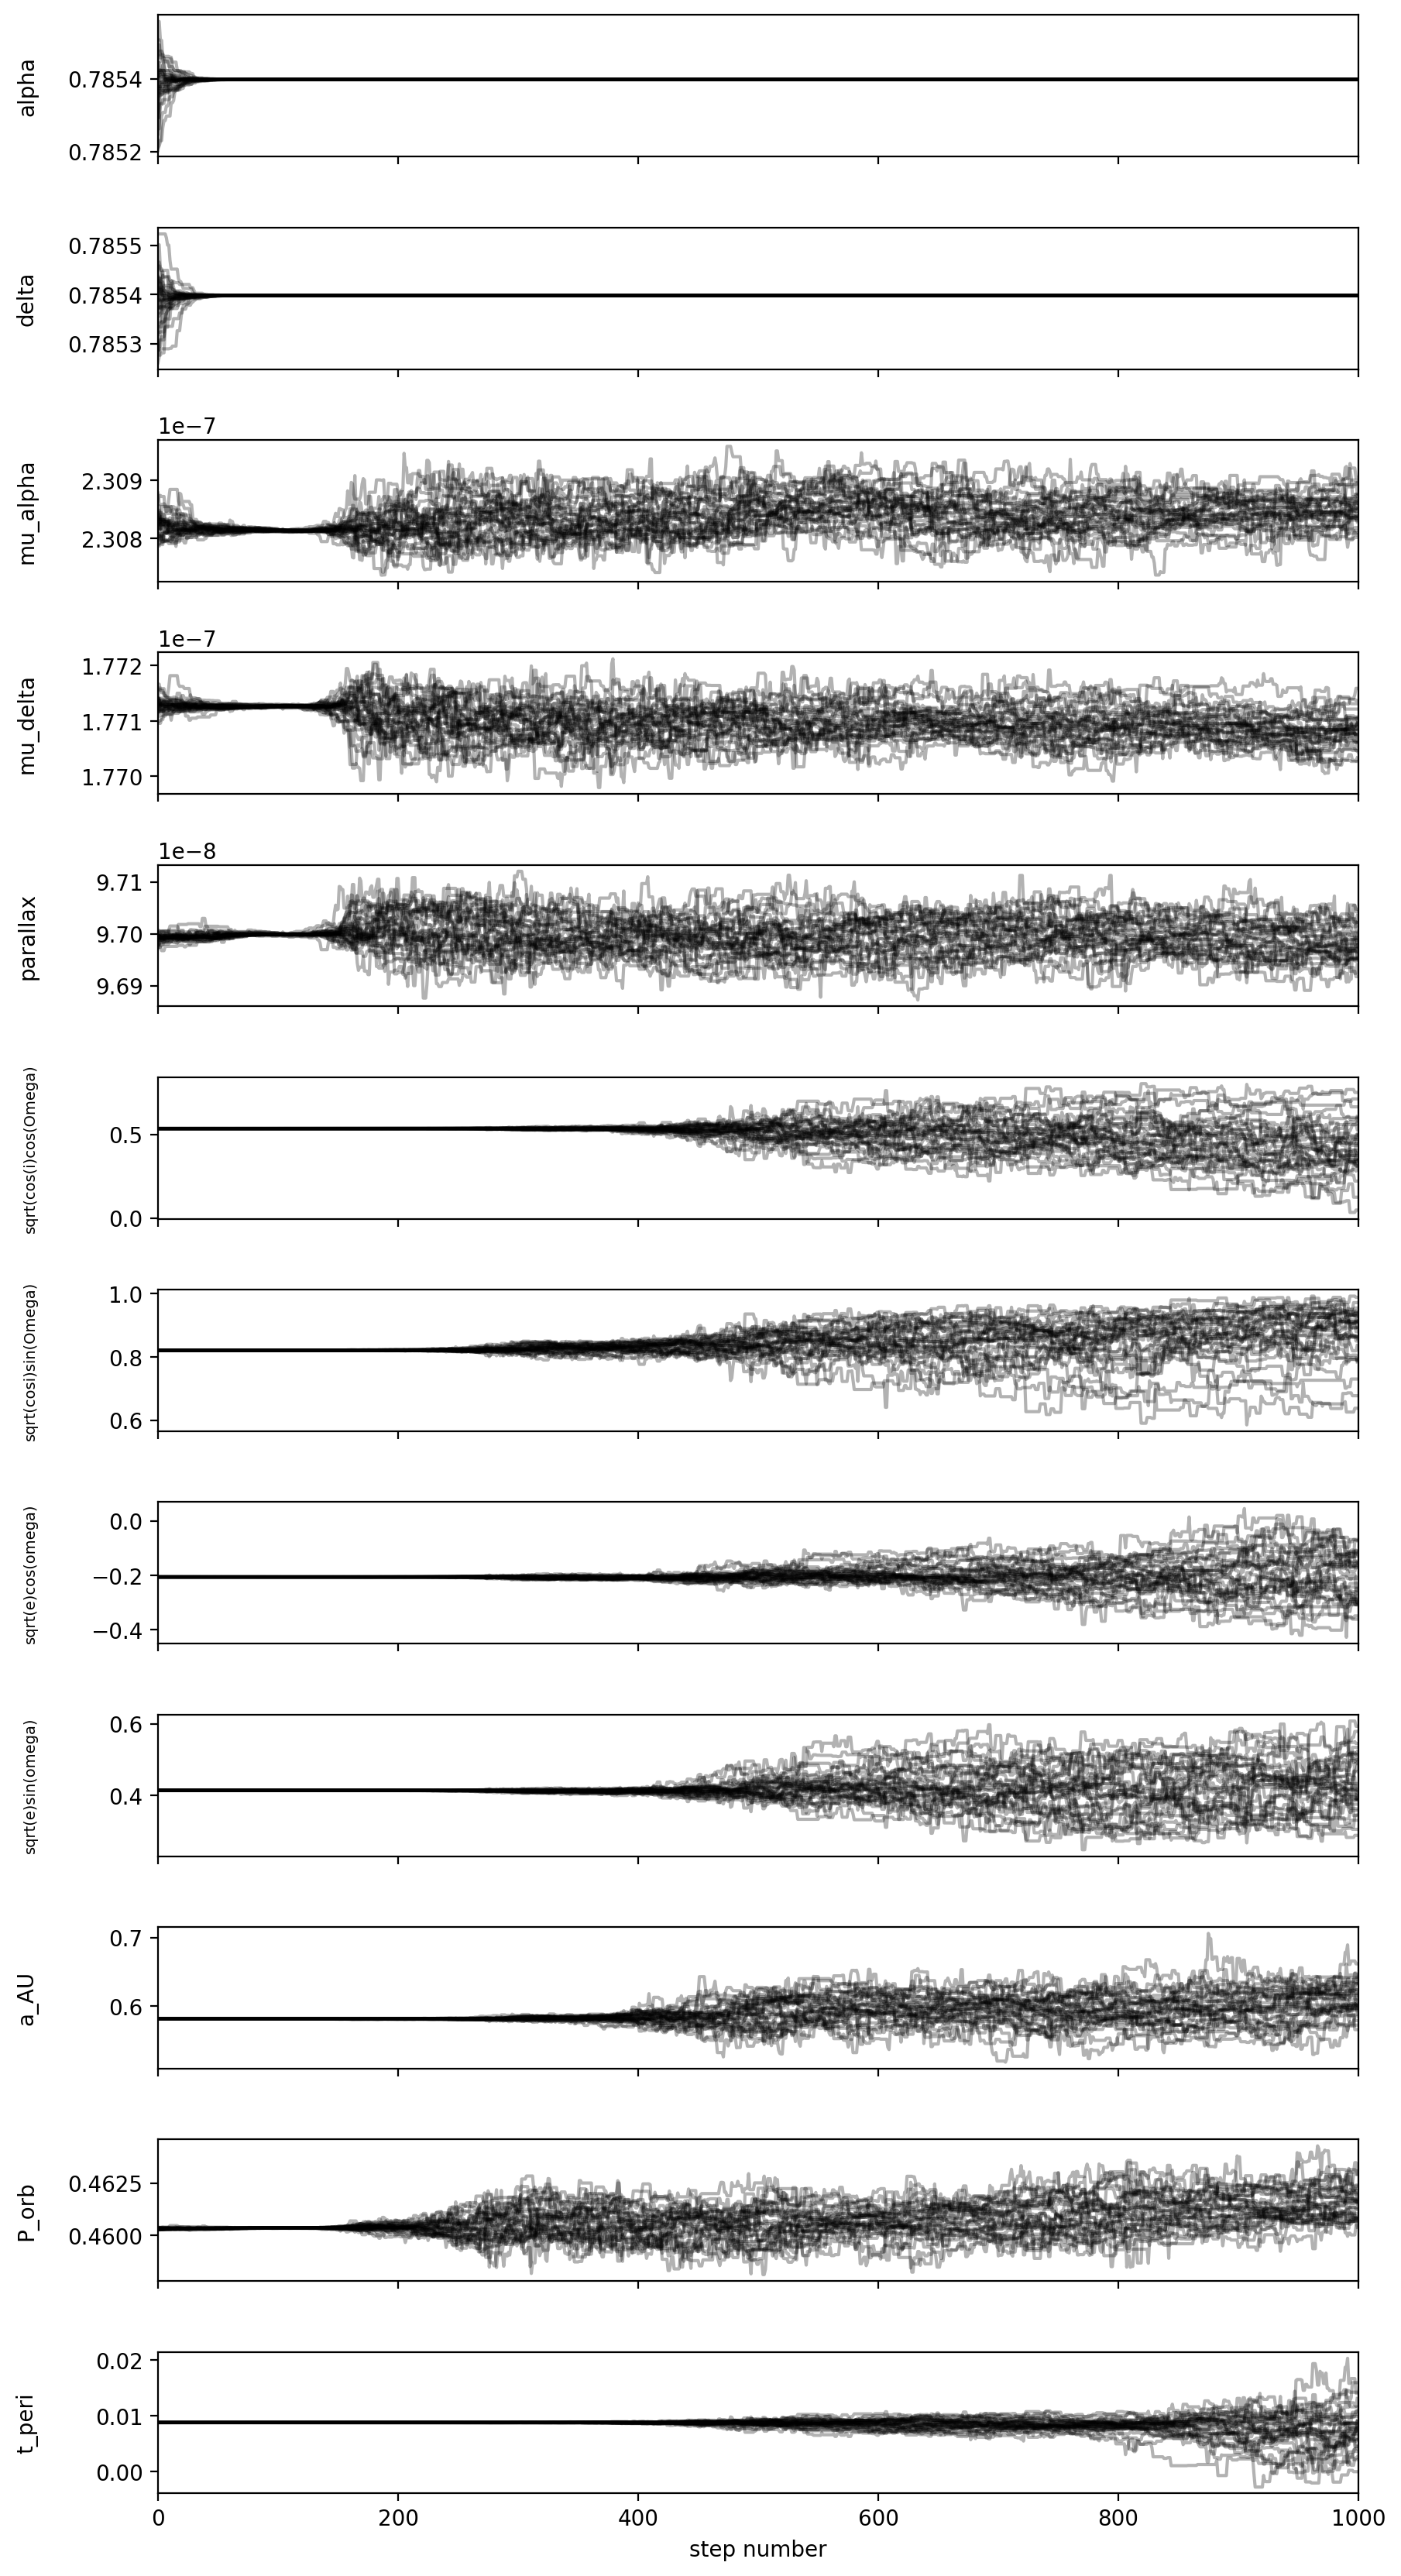

In [11]:
fig, axes = plt.subplots(12, figsize=(10, 20), sharex=True)

plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 1.5, hspace = .5)

samples = sampler.get_chain()

fontsize = [10, 10, 10, 10, 10, 7, 7, 7, 7, 10, 10, 10]


for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(parameters[i], fontsize=fontsize[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 12), sharex=False)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
ax[0].errorbar(times, (true_plnt_ra)*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[0].plot(times, (true_plnt_ra)*rad_mas, lw=3, color='red'       , label='true')

for sample in samples[-1]:
    _, _, samp_plnt_ra, samp_ra, _, _, samp_plnt_dec, samp_dec = func(sample, times)
    ax[0].plot(times, (samp_plnt_ra)*rad_mas, lw=1, color='dodgerblue', label='sample fit', ls='--')
    ax[1].plot(times, (samp_plnt_dec)*rad_mas, lw=1, color='dodgerblue', label='sample fit', ls='--', )
    
#ax[0].legend(fontsize=5)
ax[0].set_xlabel("time", fontsize = 10)
ax[0].set_ylabel("ra [mas]", fontsize = 10)
ax[0].set_title("RA Planetary Signal vs Time", fontsize = 15)

ax[1].errorbar(times, (true_plnt_dec)*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[1].plot(times, (true_plnt_dec)*rad_mas, lw=3, color='red'       , label='true')

#ax[1].legend(fontsize=5)
ax[1].set_xlabel("time", fontsize = 10)
ax[1].set_ylabel("dec [mas]", fontsize = 10)
ax[1].set_title("Dec Planetary Signal vs Time", fontsize = 15)

Estimate the integrated autocorrelation

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 14.32263774  14.61088376  82.98885807  70.3931943   62.11049504
 101.25393598 105.7317417   94.83842449  83.32060977  92.38781605
  85.29021421  88.46693483]

Flatten the chain so we have a flat list of samples 

In [13]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(1920, 12)


# Results

Make a corner plot to show MCMC results 

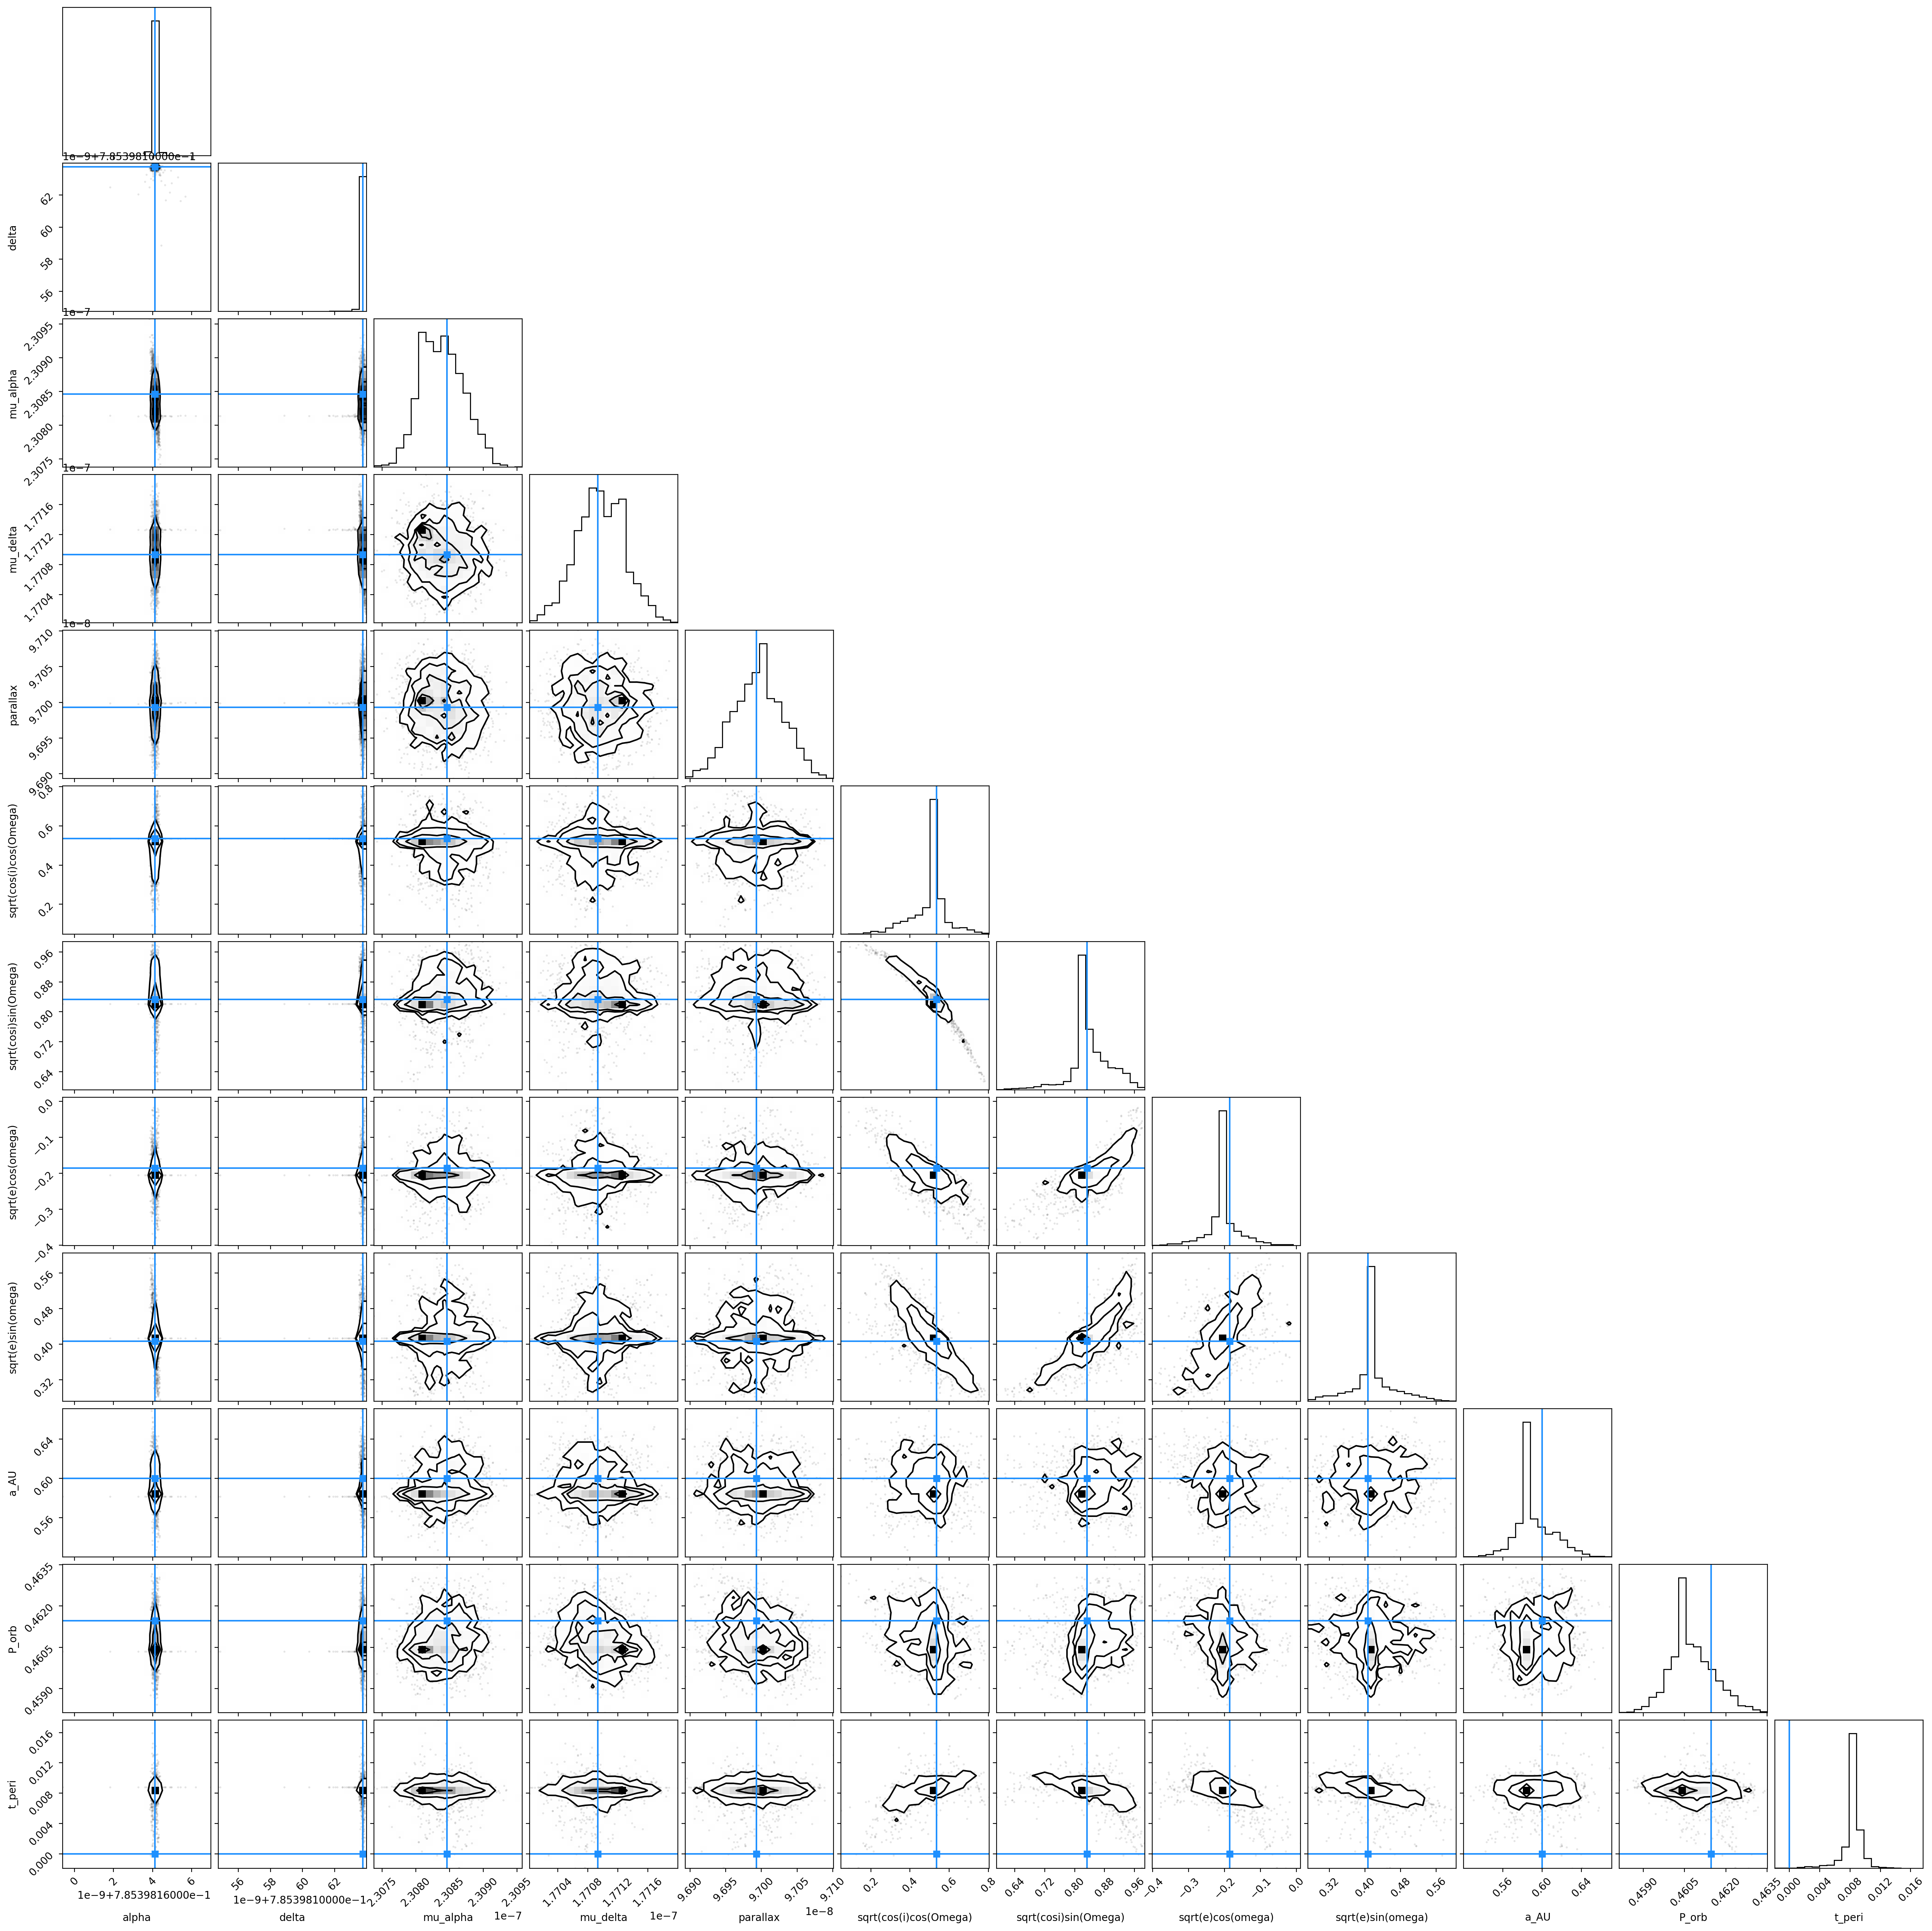

In [14]:
fig = corner.corner(
    flat_samples, labels=parameters, truths=truepars, truth_color='dodgerblue'
);